In [49]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики

from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn import preprocessing #предобработка

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

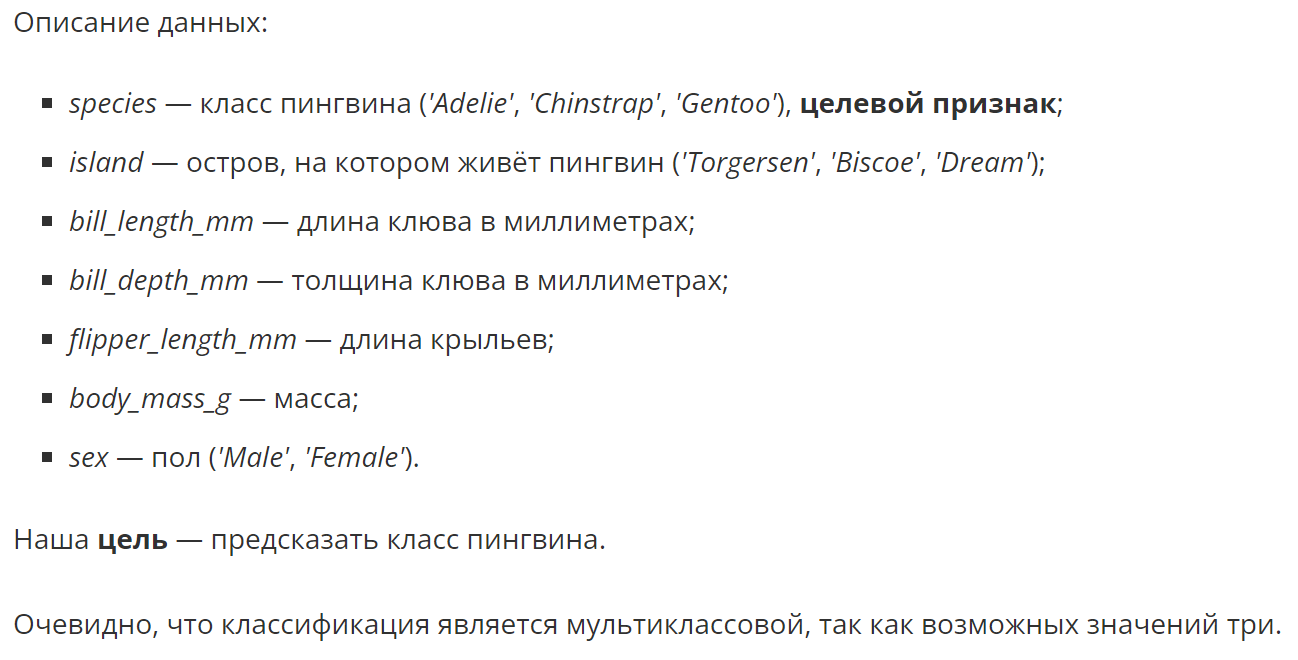

## Мультиклассовая классификация

In [50]:
penguins_data = sns.load_dataset('penguins')
penguins_data

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm   
0    Adelie  Torgersen            39.1           18.7              181.0  \
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
3    Adelie  Torgersen             NaN            NaN                NaN   
4    Adelie  Torgersen            36.7           19.3              193.0   
..      ...        ...             ...            ...                ...   
339  Gentoo     Biscoe             NaN            NaN                NaN   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g     sex  
0         3750.0    Male  
1         3800.0  Female  
2         3250.0  Female  
3            NaN     NaN  
4         3450.0  Female  
..           ...     ...  
339          NaN     NaN  
340       4850.0  Female  
341       5750.0    Male  
342       5200.0  Female  
343       5400.0    Male  

[344 rows x 7 columns]

In [51]:
# Проверка пропусков
penguins_data.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [52]:
# Удаление пропусков
penguins_data = penguins_data.dropna()

In [53]:
X = penguins_data.drop(columns='species')
y = penguins_data['species']
X

island  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g   
0    Torgersen            39.1           18.7              181.0       3750.0  \
1    Torgersen            39.5           17.4              186.0       3800.0   
2    Torgersen            40.3           18.0              195.0       3250.0   
4    Torgersen            36.7           19.3              193.0       3450.0   
5    Torgersen            39.3           20.6              190.0       3650.0   
..         ...             ...            ...                ...          ...   
338     Biscoe            47.2           13.7              214.0       4925.0   
340     Biscoe            46.8           14.3              215.0       4850.0   
341     Biscoe            50.4           15.7              222.0       5750.0   
342     Biscoe            45.2           14.8              212.0       5200.0   
343     Biscoe            49.9           16.1              213.0       5400.0   

        sex  
0      Male  
1    Female  
2    Female  
4    Female  
5      Male  
..      ...  
338  Female  
340  Female  
341    Male  
342  Female  
343    Male  

[333 rows x 6 columns]

In [54]:
y.value_counts(True) * 100

species
Adelie       43.843844
Gentoo       35.735736
Chinstrap    20.420420
Name: proportion, dtype: float64

Классы не сбалансированы. При сплитовании нужно бязательно использовать stratify!

Данные содержат строковые категориальные столбцы — island и sex. Логистическая регрессия не умеет работать со строковыми значениями. Необходимо произвести кодирование категориальных признаков.

In [55]:
X_dummies = pd.get_dummies(X, drop_first=True)
X_dummies.head()

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g   
0            39.1           18.7              181.0       3750.0  \
1            39.5           17.4              186.0       3800.0   
2            40.3           18.0              195.0       3250.0   
4            36.7           19.3              193.0       3450.0   
5            39.3           20.6              190.0       3650.0   

   island_Dream  island_Torgersen  sex_Male  
0         False              True      True  
1         False              True     False  
2         False              True     False  
4         False              True     False  
5         False              True      True

Создаём модель логистической регрессии, значение параметра multi_class выставляем на 'multinomial' (мультиклассовая классификация), max_iter — на 1000 (для обеспечения сходимости), random_state=42.

Затем обучим модель с помощью метода fit() и сделаем предсказание вероятностей принадлежности к каждому из классов с помощью метода predict_proba() и самих классов — с помощью метода predict(). Вероятности округлим до второго знака после запятой.

In [56]:
# Создаем объект класса логистическая регрессия 
log_reg = linear_model.LogisticRegression(
    multi_class='multinomial', # мультиклассовая классификация
    max_iter=1000, # количество итераций, выделенных на сходимость
    random_state=42 # генерация случайных чисел
)

# Обучаем модель 
log_reg.fit(X_dummies, y)

# Делаем предсказание вероятностей
y_pred_proba = np.round(log_reg.predict_proba(X_dummies), 2)

# Делаем предсказание класса
y_pred = log_reg.predict(X_dummies)

In [57]:
# Узнаем как модель закодировала классы
log_reg.classes_.tolist()

['Adelie', 'Chinstrap', 'Gentoo']

In [58]:
# Создаем DataFrame из вероятностей
y_pred_proba_df = pd.DataFrame(
    y_pred_proba, 
    columns=log_reg.classes_.tolist()
)

# Создаем DataFrame из предсказанных классов
y_pred_df = pd.DataFrame(
    y_pred, 
    columns=['Predicted Class']
)

# Объединяем таблицы по вертикальной оси
y_df = pd.concat([y_pred_proba_df, y_pred_df], axis=1)

# Выбираем 5 случайных строк
y_df.sample(5, random_state=2)

Adelie  Chinstrap  Gentoo Predicted Class
277     0.0        0.0     1.0          Gentoo
223     0.0        0.0     1.0          Gentoo
7       0.8        0.2     0.0          Adelie
160     0.0        1.0     0.0       Chinstrap
65      1.0        0.0     0.0          Adelie

Из таблицы можно проследить, как происходит предсказание класса пингвина на основе полученных вероятностей. Видно, что выбирается класс, вероятность принадлежности к которому максимальна.

Например, для строки под номером 7 логистическая регрессия предсказала три вероятности: 0.79 — вероятность принадлежности к классу Adelie, 0.21 — к классу Chinstrap и 0 — к классу Gentoo. На основе этих вероятностей было сделано предсказание и модель отнесла пингвина в строке 7 к классу Adelie.

Вот так и происходит мультиклассовая классификация. 

In [59]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       146
   Chinstrap       1.00      1.00      1.00        68
      Gentoo       1.00      1.00      1.00       119

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333



Для мультиклассовой классификации к отчёту просто добавляется новая строка, соответствующая третьему классу. 

Из отчёта видно, что наша модель идеально решила задачу классификации (все метрики равны 1), то есть классы оказались линейно разделимыми.